In [1]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
import torch
from torch.autograd import Variable

## import self-written packages 
from module_test import *
from util import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

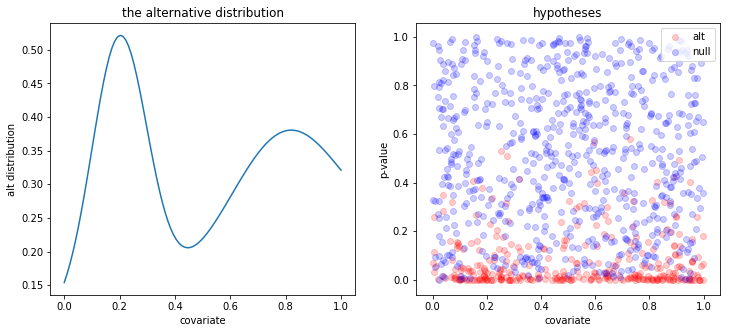

In [2]:
## generating a 1d toy data 
p,x,h=toy_data_1d(vis=1)

In [104]:
## testing the BH method
n_rej,t_rej=bh(p,alpha=0.1,vis=1)
print('FDP: %s'%str( np.sum((h==0)*(p<t_rej)/np.sum(p<t_rej))))

### Summary ###
method: BH
# rejections: 1757
rejection threshold: 0.0175268379069
### End Summary ###
FDP: 0.0893568582812


In [105]:
## testing the Storey BH method
n_rej,t_rej,pi0_hat=storey_bh(p,alpha=0.1,vis=1)
print('FDP: %s'%str( np.sum((h==0)*(p<t_rej)/np.sum(p<t_rej))))

### Summary ###
method: Storey BH
# rejections: 2196
rejection threshold: 0.0340099575341
null estimate: 0.64475
### End Summary ###
FDP: 0.129781420765


In [108]:
from sklearn.mixture import GaussianMixture
def PrimFDR_1d(p,x,alpha=0.1,h=None):    
    torch.manual_seed(24)
    n_itr    = 50000
    L        = 2
    lambda0  = 100
    lambda1  = 10000
    loss_rec = np.zeros([n_itr],dtype=float)
    n_samp   = x.shape[0]
    
    ## calculating the initialization value 
#     _,t_BH = bh(p,alpha=2*alpha)
#     x_alt  = x[p<t_BH]
#     if len(x.shape) == 1:
#         x_alt = np.reshape(x_alt,[x_alt.shape[0],1])
#     GMM    = GaussianMixture(n_components=L)
#     GMM.fit(x_alt)
    
    w_init,a_init,mu_init,sigma_init = ML_init_1d(p,x)    
    a     = a_init
    b     = np.log(w_init[0]*a_init/(np.exp(a_init)-1))
    w     = np.log(w_init[1:]/np.sqrt(2*np.pi*sigma_init**2))
    mu    = mu_init 
    sigma = 2*sigma_init**2
    
    t = np.exp(x*a+b)
    for i in range(L):
        t += sigmoid(w[i])*np.exp(-(x-mu[i])**2/sigma[i])
    gamma = n_samp*alpha/np.sum(t)/20
    b += np.log(gamma)
    w += np.log(gamma)
    
    p     = Variable(torch.from_numpy(p).float(),requires_grad=False)
    x     = Variable(torch.from_numpy(x).float(),requires_grad=False)
    
    ## initialization    
    a     = Variable(torch.Tensor([a]),requires_grad=True)
    b     = Variable(torch.Tensor([b]),requires_grad=True)
    w     = Variable(torch.Tensor(w),requires_grad=True)
    mu    = Variable(torch.Tensor(mu),requires_grad=True)
    sigma = Variable(torch.Tensor(sigma),requires_grad=True)    
    
    ## 
    print('### initialization value')
    print ('a: %s,b: %s'%(str(a.data.numpy()),str(b.data.numpy())))
    print ('w0: %s, mu0: %s, sigma0: %s'%(str(w.data.numpy()[0]),str(mu.data.numpy()[0]),str(sigma.data.numpy()[0])))
    print ('w1: %s, mu1: %s, sigma1: %s'%(str(w.data.numpy()[1]),str(mu.data.numpy()[1]),str(sigma.data.numpy()[1])))
    
    optimizer = torch.optim.Adam([a,b,w,mu,sigma],lr=0.0001)
    optimizer.zero_grad()
    
    for l in range(n_itr):
        ## calculating the model
        optimizer.zero_grad()
        t = torch.exp(x*a+b)
        for i in range(L):
            t = t+torch.exp(w[i])*torch.exp(-(x-mu[i])**2/sigma[i])
        
        loss1 = -torch.mean(torch.sigmoid(lambda0*(t-p)))
        loss2 = torch.exp(lambda1*(torch.mean(t)-alpha*torch.mean(torch.sigmoid(lambda0*(t-p)))))
        loss  = loss1+loss2
        
        ## backprop
        loss.backward()
        optimizer.step()
        
        ## show the result 
        loss_rec[l] = loss.data.numpy()
        
        if l%(int(n_itr)/5)==0:
            print('### iteration %s ###'%str(l))
            print('mean t: ', np.mean(t.data.numpy()))
            print('mean discovery: ', np.mean(t.data.numpy()>p.data.numpy()))
            print('loss1: ',loss1.data.numpy())
            print('loss2: ',loss2.data.numpy())
            print('n_rej: ',np.sum(t.data.numpy()>p.data.numpy()))
            print('Estimated FDP: %s'%str((torch.mean(t)/torch.mean(torch.sigmoid(lambda0*(t-p)))).data.numpy()))
            print('FDP: %s'%str( np.sum((h==0)*(p.data.numpy()<t.data.numpy()))/np.sum(p.data.numpy()<t.data.numpy())))
            print ('a: %s,b: %s'%(str(a.data.numpy()),str(b.data.numpy())))
            print ('w0: %s, mu0: %s, sigma0: %s'%(str(w.data.numpy()[0]),str(mu.data.numpy()[0]),str(sigma.data.numpy()[0])))
            print ('w1: %s, mu1: %s, sigma1: %s'%(str(w.data.numpy()[1]),str(mu.data.numpy()[1]),str(sigma.data.numpy()[1])))
            plt.figure()
            plot_t(t.data.numpy(),x.data.numpy())
            plt.show()
    
    
    plt.figure()
    plt.plot(loss_rec)
    plt.show()
    
    p = p.data.numpy()
    t = t.data.numpy()
    n_rej=np.sum(p<t)    
        
    return n_rej,t

### ML initialization starts ###


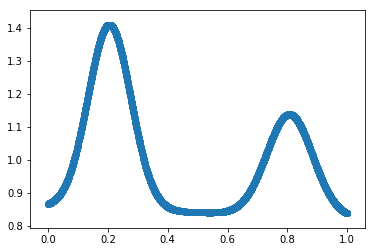

### ML initialization ends ###
### initialization value
a: [-0.03883301],b: [-5.40188456]
w0: -6.43376, mu0: 0.806758, sigma0: 0.0117841
w1: -5.83156, mu1: 0.204597, sigma1: 0.0102967
### iteration 0 ###
mean t:  0.00526429
mean discovery:  0.1182
loss1:  [-0.09956909]
loss2:  [  4.17066161e-21]
n_rej:  1182
Estimated FDP: [ 0.05287071]
FDP: 0.0363790186125
a: [-0.03873301],b: [-5.40178442]
w0: -6.43366, mu0: 0.806858, sigma0: 0.0118841
w1: -5.83146, mu1: 0.204696, sigma1: 0.0103967


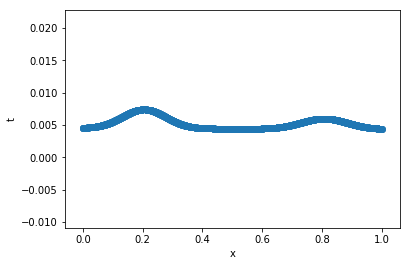

### iteration 10000 ###
mean t:  0.012892
mean discovery:  0.1586
loss1:  [-0.13606158]
loss2:  [ 0.0007916]
n_rej:  1586
Estimated FDP: [ 0.09475131]
FDP: 0.0687263556116
a: [ 0.56404179],b: [-4.82747221]
w0: -5.72892, mu0: 0.215656, sigma0: 0.0164216
w1: -5.09361, mu1: 0.215669, sigma1: 0.0164189


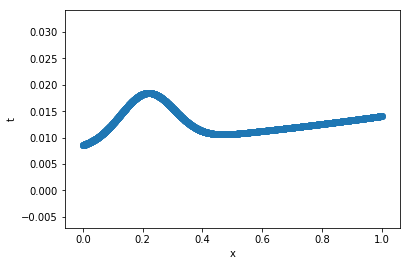

### iteration 20000 ###
mean t:  0.0131915
mean discovery:  0.1594
loss1:  [-0.13908918]
loss2:  [ 0.00076576]
n_rej:  1594
Estimated FDP: [ 0.09484169]
FDP: 0.0652446675031
a: [ 1.39532661],b: [-5.58162689]
w0: -4.78403, mu0: 0.219234, sigma0: 0.0137215
w1: -4.17074, mu1: 0.219234, sigma1: 0.0137215


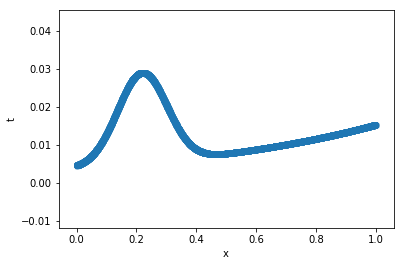

### iteration 30000 ###
mean t:  0.013263
mean discovery:  0.1595
loss1:  [-0.13982916]
loss2:  [ 0.000747]
n_rej:  1595
Estimated FDP: [ 0.09485126]
FDP: 0.0639498432602
a: [ 2.36640573],b: [-6.32705212]
w0: -4.61643, mu0: 0.2202, sigma0: 0.0140174
w1: -4.00314, mu1: 0.2202, sigma1: 0.0140174


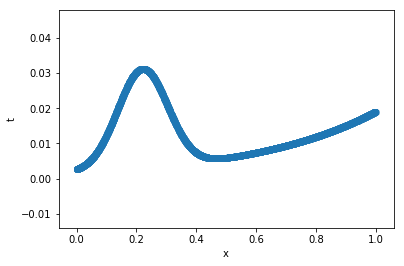

### iteration 40000 ###
mean t:  0.0132855
mean discovery:  0.1588
loss1:  [-0.14007713]
loss2:  [ 0.00073052]
n_rej:  1588
Estimated FDP: [ 0.09484445]
FDP: 0.0623425692695
a: [ 3.18460536],b: [-6.9796176]
w0: -4.5532, mu0: 0.220886, sigma0: 0.0147248
w1: -3.93991, mu1: 0.220886, sigma1: 0.0147248


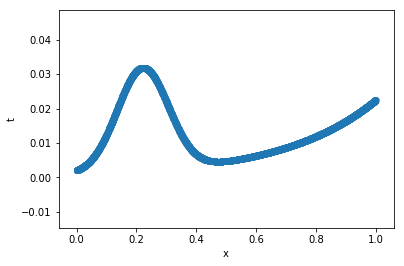

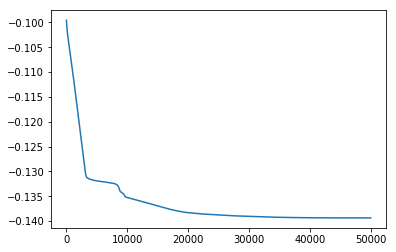

### Summary ###
method: perim_test_1d
# rejections: 1577
FDP: 0.0627774254914
### End Summary ###


In [109]:
n_rej,t=PrimFDR_1d(p,x,alpha=0.1,h=h)

print("### Summary ###")
print("method: perim_test_1d")
print("# rejections: %s"%str(n_rej))
print("FDP: %s"%str( np.sum((h==0)*(p<t))/np.sum(p<t)))
print("### End Summary ###")

### Some derivations for the implementation below ###
The slope function can be written as 
\begin{equation}
f(x;a) = \frac{a}{e^a-1} e^{ax}.
\end{equation}
Then the likihood function, with sample weight, can be written as 
\begin{equation}
l(x;a) = \sum_{i=1}^n w_i \left( ax_i + \log \frac{a}{e^a-1} \right) = a \sum_i w_i x_i + \sum_i w_i \log \frac{a}{e^a-1}. 
\end{equation}
We add a regularization factor to have 
\begin{equation}
l(x;a) = \sum_{i=1}^n w_i \left( ax_i + \log \frac{a}{e^a-1} + 0.005 a^2\right) = a \sum_i w_i x_i + \sum_i w_i \left( \log \frac{a}{e^a-1} + 0.005a^2 \right). 
\end{equation}
Hence the maximum likelihood estimate satisfies 
\begin{equation}
\frac{\log \frac{e^{\hat{a}}-1}{\hat{a}}+0.005\hat{a}^2 }{\hat{a}} = \frac{\sum_i w_i x_i}{\sum_i w_i}
\end{equation}

In [103]:
np.sum(h==1)

3314

In [66]:
import scipy as sp
from scipy import stats
from sklearn.mixture import GaussianMixture

## an EM algorithm to find the mixture model 

## fitting the slope function a/(e^a-1) e^(ax), defined over [0,1]
def ML_slope(x,w=None):
    if w is None:
        w = np.ones(x.shape[0])
    t = np.sum(w*x)/np.sum(w) ## sufficient statistic
    t=0.5
    a_u=100
    a_l=-100
    
    ## binary search 
    while a_u-a_l>0.1:
        a_m  = (a_u+a_l)/2
        a_m += 1e-2*(a_m==0)
        if (np.log((np.exp(a_m)-1)/a_m)+0.005*a_m**2)/a_m<t:
            a_l = a_m
        else: 
            a_u = a_m
    
    return (a_u+a_l)/2

def f_slope(x,a):
    return a/(np.exp(a)-1)*np.exp(a*x)

## fitting the Gaussian bump function: (using ML, but did not correct for the finite interval)
def ML_bump(x,w=None):
    if w is None:
        w = np.ones(x.shape[0])
    mu    = np.sum(x*w)/np.sum(w)
    sigma = np.sqrt(np.sum((x-mu)**2*w)/np.sum(w))
    return mu,sigma
def f_bump(x,mu,sigma): ## correct for the finite interval issue
    pmf = sp.stats.norm.cdf(1,loc=mu,scale=sigma)-sp.stats.norm.cdf(0,loc=mu,scale=sigma)
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/2/sigma**2)/pmf

def f_all(x,a,mu,sigma,w):
    f = w[0]*f_slope(x,a)
    for k in range(1,w.shape[0]):
        f += w[k]*f_bump(x,mu[k-1],sigma[k-1])
    return f

def ML_init_1d(p,x,alpha=0.2,vis=0):
    print('### ML initialization starts ###')
    np.random.seed(42)
    n_itr    = 100
    K        = 2
    
    ## EM to fit the data 
    _,t_BH = bh(p,alpha=2*alpha)
    x_alt  = x[p<t_BH]
    n_samp = x_alt.shape[0]
    
    if len(x.shape) == 1:
        x_alt_ = np.reshape(x_alt,[n_samp,1])
    GMM = GaussianMixture(n_components=K)
    GMM.fit(x_alt_)
    
    ## initialization
    w     = np.ones([K+1])/(K+1)
    a     = ML_slope(x_alt)
    mu    = GMM.means_.reshape([K])
    sigma = GMM.covariances_.reshape([K])
    w_samp = np.zeros([K+1,n_samp],dtype=float)
    
    for i in range(n_itr):
        ## E step       
        w_samp[0,:] = w[0]*f_slope(x_alt,a)
        for k in range(K):
            w_samp[k+1,:] = w[k+1]*f_bump(x_alt,mu[k],sigma[k])
        w_samp = w_samp/np.sum(w_samp,axis=0)
        
        ## M step
        a = ML_slope(x_alt,w_samp[0,:])
        for k in range(K):
            mu[k],sigma[k]=ML_bump(x_alt,w_samp[k+1,:])
        w = np.mean(w_samp,axis=1)
        
        if vis == 1:
            if i%(int(n_itr/5))==0:
                temp=np.linspace(0,1,101)

                print('### iteration %s'%str(i))
                print(np.sum(x_alt*w_samp[0,:]),np.sum(w_samp[0,:]),np.sum(x_alt*w_samp[0,:])/np.sum(w_samp[0,:]))
                print(w,a,mu,sigma)
                plt.figure()
                plt.plot(temp,w[0]*f_slope(temp,a))
                plt.plot(temp,w[1]*f_bump(temp,mu[0],sigma[0]))
                plt.plot(temp,w[2]*f_bump(temp,mu[1],sigma[1]))
                plt.show()
    
    plt.figure()
    plt.scatter(x_alt,f_all(x_alt,a,mu,sigma,w))
    plt.show()
    
    print('### ML initialization ends ###')
    return w,a,mu,sigma

### ML initialization starts ###
### iteration 0
1524.11892533 3102.12464078 0.491314534978
[ 0.78455353  0.09937371  0.11607277] -0.0388330078125 [ 0.76208811  0.24717985] [ 0.03292028  0.03152264]


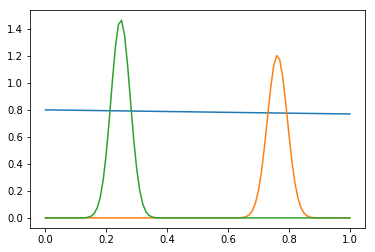

### iteration 200
1666.40325146 3321.02772128 0.501773363944
[ 0.83991596  0.05926983  0.1008142 ] -0.0388330078125 [ 0.806315    0.20480552] [ 0.07705802  0.07198275]


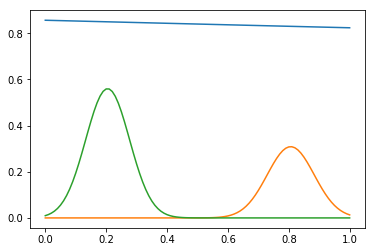

### iteration 400
1666.37196015 3320.96569726 0.501773312963
[ 0.83990028  0.05927782  0.1008219 ] -0.0388330078125 [ 0.80630762  0.20480885] [ 0.07706293  0.07198644]


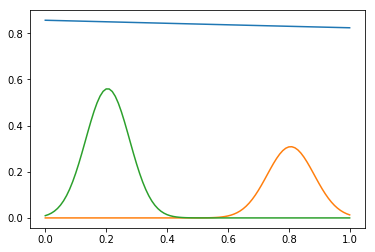

### iteration 600
1666.37195154 3320.9656802 0.501773312949
[ 0.83990027  0.05927782  0.10082191] -0.0388330078125 [ 0.80630761  0.20480885] [ 0.07706293  0.07198644]


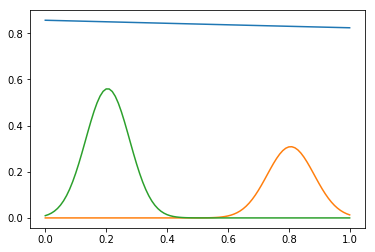

### iteration 800
1666.37195154 3320.96568019 0.501773312949
[ 0.83990027  0.05927782  0.10082191] -0.0388330078125 [ 0.80630761  0.20480885] [ 0.07706293  0.07198644]


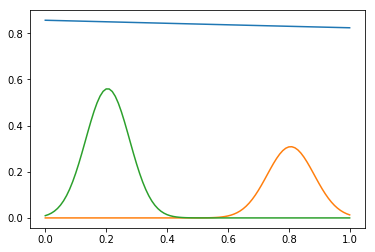

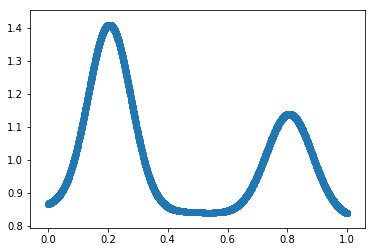

### ML initialization ends ###


In [58]:
w,a,mu,sigma = ML_init_1d(p,x)